# Consider Scaling of the Upward-directed SWF for Clearsky

We develop curves of SWF upwelling as function of SWF downwelling.

## Load Standard and User Libraries

In [1]:
%matplotlib inline

import os, sys, copy, glob
import numpy as np
import datetime
import seaborn as sns
import pylab as pl
import xarray as xr

In [2]:
pl.rcParams['figure.figsize'] = (16.0, 8.0)
pl.rcParams['font.size'] = 18.0
pl.rcParams['lines.linewidth'] = 3

In [3]:
from tropy.standard_config import local_data_path
import tropy.analysis_tools.grid_and_interpolation as gi
import tropy.analysis_tools.statistics as stats

In [4]:
import nawdex_analysis.analysis.ave_cre
import nawdex_analysis.io.collector

from nawdex_analysis.plot.exp_layout import get_exp_kws


## Collect Data

In [5]:
rset = nawdex_analysis.io.collector.get_radflux4set( 'all', method = 'strict'  )


## Scale Clearsky

In [6]:
scaling_factor = 0.88

In [7]:
nawdex_analysis.analysis.ave_cre.radflux2cre( rset, scaling = True, new_factor = scaling_factor, old_factor = 0.9 )

In [8]:
idlist = list( rset.idname.data )
#idlist.remove('msevi-scaled')


In [9]:
rclear = rset.sel(ct = 'clear_ocean', idname = idlist)


## Do Conditional Analysis

In [10]:
cond = xr.Dataset()

bins = np.linspace(0,1000,11)
percentiles = [10, 25, 50, 75, 90]

mbins = gi.lmean(bins)

idlist.remove('msevi-scaled')
idlist.remove('msevi-not_scaled')

idlist.insert(0, 'msevi-scaled')

for i, idname in enumerate( idlist ): 

    v1 = -rclear.sel(idname = idname)['swf_down']
    v2 = rclear.sel(idname = idname)['swf_up']
    
    # calculate conditioned statistics
    mbins = gi.lmean(bins)
    v2p = stats.cond_perc_simple(v1, v2, bins, p=percentiles)

    cond[idname] = xr.DataArray(v2p, coords=[percentiles, mbins], dims=['percentiles', 'bins'])


In [11]:
idlist.insert(0, 'icon-scaled')

cond['icon-scaled'] = cond['10km_oneMom_Conv'].copy() * scaling_factor 

In [12]:
cond

<xarray.Dataset>
Dimensions:            (bins: 10, percentiles: 5)
Coordinates:
  * percentiles        (percentiles) int64 10 25 50 75 90
  * bins               (bins) float64 50.0 150.0 250.0 ... 750.0 850.0 950.0
Data variables:
    msevi-scaled       (percentiles, bins) float64 0.0 29.54 ... 92.14 93.95
    10km_oneMom_Conv   (percentiles, bins) float64 0.0 26.57 ... 105.9 109.0
    10km_twoMom_Conv   (percentiles, bins) float64 0.0 27.27 ... 105.0 107.0
    20km_oneMom_Conv   (percentiles, bins) float64 0.0 29.04 ... 106.7 110.1
    20km_twoMom_Conv   (percentiles, bins) float64 0.0 27.43 ... 105.4 108.3
    2km_oneMom_noConv  (percentiles, bins) float64 0.0 26.72 ... 111.4 110.2
    2km_oneMom_shConv  (percentiles, bins) float64 0.0 27.72 ... 104.1 106.5
    2km_twoMom_noConv  (percentiles, bins) float64 0.0 25.16 ... 112.4 111.3
    2km_twoMom_shConv  (percentiles, bins) float64 0.0 25.34 ... 102.5 107.5
    40km_oneMom_Conv   (percentiles, bins) float64 0.0 27.91 ... 108.2 110.9

## Plot Downwelling vs. Upwelling SWF 

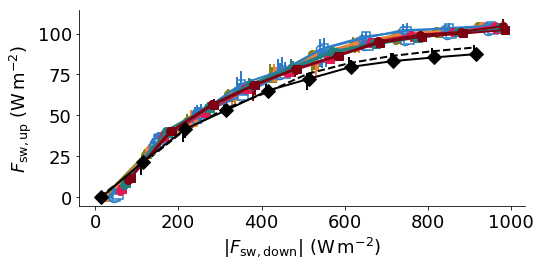

In [13]:
pl.figure( figsize = (8,4))

nvars = len(idlist)
scal = 5
offset = -scal * nvars / 2.

for i, idname in enumerate( idlist ): 
    kws = get_exp_kws( idname, ptype = 'points' )
    kws['linewidth'] = 2
    
    if idname == 'icon-scaled':
        kws['linestyle'] = '--'
        kws['color'] = 'k'
    
    # calculate conditioned statistics
    mbins = cond['bins'].data
    v2p = cond[idname].data
    
    ymed = v2p[2]
    yerr = np.abs( v2p[[1,3]] - v2p[2] )
    
    # use shifted bins for visualization
    sbins = mbins + scal * i + offset
    ys = np.interp(sbins, mbins, ymed)
    
    
    
    pl.errorbar(sbins, ys, yerr = yerr, label = idname, **kws)
    
sns.despine()
pl.xlabel('$|F_\mathrm{sw, down}|$ ($\mathrm{W\,m^{-2}}$)')  
pl.ylabel('$F_\mathrm{sw, up}$ ($\mathrm{W\,m^{-2}}$)')  

pl.subplots_adjust(bottom = 0.2)
pl.savefig('../pics/scaling_of_upwelling_clearsky.png', dpi = 300)

#pl.legend(loc = 'center right', bbox_to_anchor=(1.3, 0.5) )

icon-scaled
{'linewidth': 2, 'color': 'k', 'markersize': 8, 'linestyle': '--'}
msevi-scaled
{'color': 'k', 'markersize': 10, 'zorder': 10, 'marker': 'D', 'linewidth': 2, 'linestyle': '-'}
10km_oneMom_Conv
{'color': '#7d8111', 'marker': 'o', 'markersize': 8, 'linewidth': 2, 'fillstyle': 'full'}


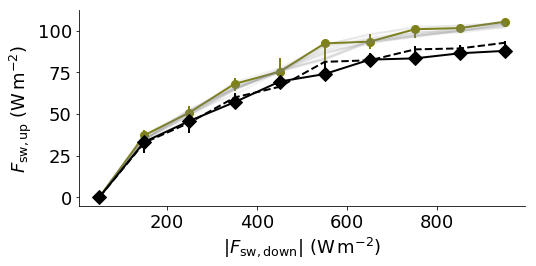

In [18]:
pl.figure( figsize = (8,4))

nvars = len(idlist)
scal = 5
offset = -scal * nvars / 2.

for i, idname in enumerate( idlist ): 
    
   
    kws = get_exp_kws( idname, ptype = 'points' )
    kws['linewidth'] = 2
    
    if idname == 'icon-scaled':
        kws['linestyle'] = '--'
        kws['color'] = 'k'
    
    
    # calculate conditioned statistics
    mbins = cond['bins'].data
    v2p = cond[idname].data
    
    ymed = v2p[2]
    yerr = np.abs( v2p[[1,3]] - v2p[2] )
    
    # use shifted bins for visualization
    sbins = mbins + scal * i + offset
    
    # no shifted bins
    sbins = mbins
    ys = np.interp(sbins, mbins, ymed)
    
    if idname not in ['msevi-scaled', '10km_oneMom_Conv', 'icon-scaled']:
        kws['color'] = 'gray'
        kws['linestyle'] = '-'
        kws['alpha'] = 0.1
        kws['marker'] = None
        yerr = 0
    else:
        print(idname)
        print(kws)
    
    pl.errorbar(sbins, ys, yerr = yerr, label = idname, **kws)
    
sns.despine()
pl.xlabel('$|F_\mathrm{sw, down}|$ ($\mathrm{W\,m^{-2}}$)')  
pl.ylabel('$F_\mathrm{sw, up}$ ($\mathrm{W\,m^{-2}}$)')  

pl.subplots_adjust(bottom = 0.2)
pl.savefig('../pics/scaling_of_upwelling_clearsky.png', dpi = 300)

#pl.legend(loc = 'center right', bbox_to_anchor=(1.3, 0.5) )

In [15]:
cond

<xarray.Dataset>
Dimensions:            (bins: 10, percentiles: 5)
Coordinates:
  * percentiles        (percentiles) int64 10 25 50 75 90
  * bins               (bins) float64 50.0 150.0 250.0 ... 750.0 850.0 950.0
Data variables:
    msevi-scaled       (percentiles, bins) float64 0.0 29.54 ... 92.14 93.95
    10km_oneMom_Conv   (percentiles, bins) float64 0.0 26.57 ... 105.9 109.0
    10km_twoMom_Conv   (percentiles, bins) float64 0.0 27.27 ... 105.0 107.0
    20km_oneMom_Conv   (percentiles, bins) float64 0.0 29.04 ... 106.7 110.1
    20km_twoMom_Conv   (percentiles, bins) float64 0.0 27.43 ... 105.4 108.3
    2km_oneMom_noConv  (percentiles, bins) float64 0.0 26.72 ... 111.4 110.2
    2km_oneMom_shConv  (percentiles, bins) float64 0.0 27.72 ... 104.1 106.5
    2km_twoMom_noConv  (percentiles, bins) float64 0.0 25.16 ... 112.4 111.3
    2km_twoMom_shConv  (percentiles, bins) float64 0.0 25.34 ... 102.5 107.5
    40km_oneMom_Conv   (percentiles, bins) float64 0.0 27.91 ... 108.2 110.9